Video Classification Model : https://towardsdatascience.com/transfer-learning-using-mobilenet-and-keras-c75daf7ff299

## STEP 1:  import the required libraries

In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense, InputLayer, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import cv2
from glob import glob
import os

from keras import backend as K
from keras.layers.core import Dense, Activation
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.applications import imagenet_utils
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input
from IPython.display import Image
from keras.optimizers import Adam

Using TensorFlow backend.


## STEP 2: Read each frame and their corresponding tag

In [2]:
train = pd.read_csv('train_new.csv')
train.head()

,image,class
0,A_OffSide_shot1.mp4_frame0.jpg,OffSide
1,A_OffSide_shot1.mp4_frame1.jpg,OffSide
2,A_OffSide_shot1.mp4_frame10.jpg,OffSide
3,A_OffSide_shot1.mp4_frame11.jpg,OffSide
4,A_OffSide_shot1.mp4_frame12.jpg,OffSide


## STEP 3: Read the frames and then store them as a NumPy array

In [3]:
# creating an empty list
train_image = []

# for loop to read and store frames
for i in tqdm(range(train.shape[0])):
    # loading the image and keeping the target size as (224,224,3)
    img = image.load_img('train_1/'+train['image'][i], target_size=(224,224,3))
    # converting it to array
    img = image.img_to_array(img)
    # normalizing the pixel value
    img = img/255
    # appending the image to the train_image list
    train_image.append(img)
    
# converting the list to numpy array
X = np.array(train_image)

# shape of the array
X.shape

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2809/2809 [00:19<00:00, 144.70it/s]


(2809, 224, 224, 3)

## STEP 4: Create the validation set

In [4]:
# separating the target
y = train['class']

In [5]:
# creating the training and validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify = y)

## STEP 5: Create 4 different columns in the target, one for each category

In [6]:
# creating dummies of target variable for train and validation set
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

In [7]:
train['class'].value_counts()

OffSide     1689
Legside      665
Straight     455
Name: class, dtype: int64

## STEP 6: Use the MobileNet pre-trained model to create the base model

Lets now re-use MobileNet as it is quite lightweight (17Mb), freeze the base layers and lets add and train the top few layers (https://machinethink.net/blog/compressing-deep-neural-nets/)

In [8]:
#imports the mobilenet model and discards the last 1000 neuron layer.
base_model = MobileNet(weights='imagenet',include_top=False) 


C:\Users\Jatin_Thakkar\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\keras_applications\mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


## STEP 7: Extract features from this pre-trained model for our training and validation images

In [9]:
# extracting features for training frames
X_train = base_model.predict(X_train)
X_train.shape

(2247, 7, 7, 1024)

In [10]:
# extracting features for validation frames
X_test = base_model.predict(X_test)
X_test.shape

(562, 7, 7, 1024)

## STEP 8: reshape the images into a single dimension

In [11]:
# reshaping the training as well as validation frames in single dimension
X_train = X_train.reshape(2247, 7*7*1024)
X_test = X_test.reshape(562, 7*7*1024)

## STEP 9: Normalize the pixel values (between 0 and 1, helps the model to converge faster)

In [12]:
# normalizing the pixel values
max = X_train.max()
X_train = X_train/max
X_test = X_test/max

## STEP 10: Create the architecture of the model

In [13]:
# shape of images
X_train.shape

(2247, 50176)

In [14]:
#defining the model architecture
model = Sequential()
model.add(Dense(1024, activation='relu', input_shape=(50176,)))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## STEP 11: Train our model using the training frames and validate using validation frames

In [15]:
# defining a function to save the weights of best model
from keras.callbacks import ModelCheckpoint
mcp_save = ModelCheckpoint('weight_MobileNet.hdf5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)

Improving Generalization Performance by Switching from Adam to SGD
(https://towardsdatascience.com/normalized-direction-preserving-adam-switching-from-adam-to-sgd-and-nesterov-momentum-adam-with-460be5ddf686)

In [16]:
# compiling the model
from keras.optimizers import SGD
opt = SGD()
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              51381248  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
__________

In [18]:
# training the model
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[mcp_save], batch_size=64, verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 2247 samples, validate on 562 samples
Epoch 1/50
2247/2247 [==============================] - ETA: 1:31 - loss: 1.1993 - acc: 0.375 - ETA: 49s - loss: 1.1919 - acc: 0.375 - ETA: 36s - loss: 1.1376 - acc: 0.43 - ETA: 28s - loss: 1.1282 - acc: 0.46 - ETA: 24s - loss: 1.1165 - acc: 0.47 - ETA: 22s - loss: 1.1200 - acc: 0.48 - ETA: 19s - loss: 1.1161 - acc: 0.50 - ETA: 17s - loss: 1.1006 - acc: 0.51 - ETA: 16s - loss: 1.1038 - acc: 0.51 - ETA: 15s - loss: 1.1114 - acc: 0.51 - ETA: 14s - loss: 1.1021 - acc: 0.51 - ETA: 13s - loss: 1.0931 - acc: 0.52 - ETA: 12s - loss: 1.0855 - acc: 0.52 - ETA: 11s - loss: 1.0897 - acc: 0.52 - ETA: 10s - loss: 1.0935 - acc: 0.51 - ETA: 10s - loss: 1.0813 - acc: 0.52 - ETA: 9s - loss: 1.0705 - acc: 0.5303 - ETA: 8s - loss: 1.0712 - acc: 0.530 - ETA: 8s - loss: 1.0721 - acc: 0.528 - ETA: 7s - loss: 1.0683 - acc: 0.532 - ETA: 7s - loss: 1.0633 - acc: 0.532 - E

Epoch 00005: val_loss improved from 0.68795 to 0.62770, saving model to weight_MobileNet.hdf5
Epoch 6/50
2247/2247 [==============================] - ETA: 15s - loss: 0.7758 - acc: 0.67 - ETA: 14s - loss: 0.7704 - acc: 0.64 - ETA: 13s - loss: 0.7371 - acc: 0.67 - ETA: 13s - loss: 0.7417 - acc: 0.66 - ETA: 13s - loss: 0.7630 - acc: 0.65 - ETA: 13s - loss: 0.7447 - acc: 0.65 - ETA: 13s - loss: 0.7380 - acc: 0.66 - ETA: 13s - loss: 0.7317 - acc: 0.66 - ETA: 13s - loss: 0.7349 - acc: 0.67 - ETA: 13s - loss: 0.7238 - acc: 0.68 - ETA: 12s - loss: 0.7147 - acc: 0.68 - ETA: 12s - loss: 0.7080 - acc: 0.69 - ETA: 11s - loss: 0.7115 - acc: 0.68 - ETA: 10s - loss: 0.7014 - acc: 0.69 - ETA: 10s - loss: 0.7140 - acc: 0.68 - ETA: 9s - loss: 0.7210 - acc: 0.6875 - ETA: 9s - loss: 0.7109 - acc: 0.695 - ETA: 8s - loss: 0.7111 - acc: 0.693 - ETA: 8s - loss: 0.7143 - acc: 0.692 - ETA: 7s - loss: 0.7146 - acc: 0.689 - ETA: 7s - loss: 0.7165 - acc: 0.689 - ETA: 6s - loss: 0.7086 - acc: 0.692 - ETA: 6s - los

2247/2247 [==============================] - ETA: 12s - loss: 0.2792 - acc: 0.90 - ETA: 16s - loss: 0.3013 - acc: 0.89 - ETA: 15s - loss: 0.3085 - acc: 0.88 - ETA: 13s - loss: 0.3242 - acc: 0.87 - ETA: 13s - loss: 0.3425 - acc: 0.86 - ETA: 12s - loss: 0.3449 - acc: 0.85 - ETA: 11s - loss: 0.3489 - acc: 0.85 - ETA: 11s - loss: 0.3598 - acc: 0.84 - ETA: 11s - loss: 0.3632 - acc: 0.84 - ETA: 10s - loss: 0.3580 - acc: 0.85 - ETA: 10s - loss: 0.3583 - acc: 0.85 - ETA: 10s - loss: 0.3575 - acc: 0.85 - ETA: 9s - loss: 0.3485 - acc: 0.8606 - ETA: 9s - loss: 0.3532 - acc: 0.857 - ETA: 9s - loss: 0.3497 - acc: 0.860 - ETA: 8s - loss: 0.3565 - acc: 0.857 - ETA: 8s - loss: 0.3578 - acc: 0.856 - ETA: 8s - loss: 0.3594 - acc: 0.855 - ETA: 7s - loss: 0.3604 - acc: 0.852 - ETA: 7s - loss: 0.3563 - acc: 0.855 - ETA: 6s - loss: 0.3512 - acc: 0.857 - ETA: 6s - loss: 0.3464 - acc: 0.860 - ETA: 5s - loss: 0.3428 - acc: 0.864 - ETA: 5s - loss: 0.3443 - acc: 0.864 - ETA: 4s - loss: 0.3515 - acc: 0.861 - ETA:

2247/2247 [==============================] - ETA: 19s - loss: 0.2700 - acc: 0.84 - ETA: 16s - loss: 0.1750 - acc: 0.91 - ETA: 15s - loss: 0.2199 - acc: 0.91 - ETA: 13s - loss: 0.2256 - acc: 0.91 - ETA: 13s - loss: 0.2082 - acc: 0.91 - ETA: 13s - loss: 0.2086 - acc: 0.92 - ETA: 12s - loss: 0.1886 - acc: 0.93 - ETA: 12s - loss: 0.1849 - acc: 0.93 - ETA: 11s - loss: 0.1890 - acc: 0.93 - ETA: 11s - loss: 0.1839 - acc: 0.93 - ETA: 11s - loss: 0.1782 - acc: 0.94 - ETA: 10s - loss: 0.1732 - acc: 0.94 - ETA: 10s - loss: 0.1710 - acc: 0.94 - ETA: 9s - loss: 0.1709 - acc: 0.9420 - ETA: 9s - loss: 0.1721 - acc: 0.942 - ETA: 8s - loss: 0.1692 - acc: 0.944 - ETA: 8s - loss: 0.1650 - acc: 0.944 - ETA: 7s - loss: 0.1608 - acc: 0.947 - ETA: 7s - loss: 0.1618 - acc: 0.949 - ETA: 6s - loss: 0.1608 - acc: 0.949 - ETA: 6s - loss: 0.1592 - acc: 0.950 - ETA: 5s - loss: 0.1566 - acc: 0.952 - ETA: 5s - loss: 0.1540 - acc: 0.953 - ETA: 4s - loss: 0.1528 - acc: 0.954 - ETA: 4s - loss: 0.1509 - acc: 0.954 - ETA:

2247/2247 [==============================] - ETA: 12s - loss: 0.1256 - acc: 0.96 - ETA: 12s - loss: 0.1725 - acc: 0.93 - ETA: 11s - loss: 0.1468 - acc: 0.95 - ETA: 11s - loss: 0.1252 - acc: 0.95 - ETA: 11s - loss: 0.1190 - acc: 0.95 - ETA: 11s - loss: 0.1139 - acc: 0.96 - ETA: 11s - loss: 0.1122 - acc: 0.96 - ETA: 10s - loss: 0.1132 - acc: 0.96 - ETA: 10s - loss: 0.1142 - acc: 0.96 - ETA: 9s - loss: 0.1097 - acc: 0.9656 - ETA: 9s - loss: 0.1034 - acc: 0.968 - ETA: 9s - loss: 0.0988 - acc: 0.970 - ETA: 9s - loss: 0.0957 - acc: 0.972 - ETA: 8s - loss: 0.0920 - acc: 0.974 - ETA: 8s - loss: 0.0916 - acc: 0.975 - ETA: 7s - loss: 0.0934 - acc: 0.974 - ETA: 7s - loss: 0.0936 - acc: 0.974 - ETA: 6s - loss: 0.0937 - acc: 0.974 - ETA: 6s - loss: 0.0914 - acc: 0.975 - ETA: 6s - loss: 0.0924 - acc: 0.975 - ETA: 5s - loss: 0.0903 - acc: 0.976 - ETA: 5s - loss: 0.0884 - acc: 0.977 - ETA: 5s - loss: 0.0879 - acc: 0.977 - ETA: 4s - loss: 0.0869 - acc: 0.977 - ETA: 4s - loss: 0.0843 - acc: 0.978 - ETA:

2247/2247 [==============================] - ETA: 14s - loss: 0.0287 - acc: 1.00 - ETA: 13s - loss: 0.0437 - acc: 0.99 - ETA: 12s - loss: 0.0359 - acc: 0.99 - ETA: 12s - loss: 0.0308 - acc: 0.99 - ETA: 11s - loss: 0.0291 - acc: 0.99 - ETA: 11s - loss: 0.0289 - acc: 0.99 - ETA: 10s - loss: 0.0343 - acc: 0.99 - ETA: 10s - loss: 0.0345 - acc: 0.99 - ETA: 10s - loss: 0.0349 - acc: 0.99 - ETA: 9s - loss: 0.0337 - acc: 0.9969 - ETA: 9s - loss: 0.0325 - acc: 0.997 - ETA: 9s - loss: 0.0341 - acc: 0.997 - ETA: 8s - loss: 0.0330 - acc: 0.997 - ETA: 8s - loss: 0.0320 - acc: 0.997 - ETA: 8s - loss: 0.0313 - acc: 0.997 - ETA: 7s - loss: 0.0335 - acc: 0.997 - ETA: 7s - loss: 0.0331 - acc: 0.997 - ETA: 6s - loss: 0.0343 - acc: 0.996 - ETA: 6s - loss: 0.0347 - acc: 0.995 - ETA: 5s - loss: 0.0350 - acc: 0.996 - ETA: 5s - loss: 0.0367 - acc: 0.993 - ETA: 5s - loss: 0.0378 - acc: 0.992 - ETA: 4s - loss: 0.0394 - acc: 0.991 - ETA: 4s - loss: 0.0403 - acc: 0.991 - ETA: 4s - loss: 0.0408 - acc: 0.991 - ETA:

2247/2247 [==============================] - ETA: 17s - loss: 0.0265 - acc: 1.00 - ETA: 15s - loss: 0.0231 - acc: 1.00 - ETA: 15s - loss: 0.0274 - acc: 0.99 - ETA: 14s - loss: 0.0278 - acc: 0.99 - ETA: 13s - loss: 0.0273 - acc: 0.99 - ETA: 13s - loss: 0.0268 - acc: 0.99 - ETA: 12s - loss: 0.0271 - acc: 0.99 - ETA: 12s - loss: 0.0280 - acc: 0.99 - ETA: 12s - loss: 0.0286 - acc: 0.99 - ETA: 11s - loss: 0.0278 - acc: 0.99 - ETA: 11s - loss: 0.0261 - acc: 0.99 - ETA: 10s - loss: 0.0250 - acc: 0.99 - ETA: 10s - loss: 0.0243 - acc: 0.99 - ETA: 9s - loss: 0.0239 - acc: 0.9955 - ETA: 9s - loss: 0.0245 - acc: 0.994 - ETA: 8s - loss: 0.0245 - acc: 0.995 - ETA: 8s - loss: 0.0250 - acc: 0.995 - ETA: 7s - loss: 0.0249 - acc: 0.995 - ETA: 7s - loss: 0.0250 - acc: 0.995 - ETA: 6s - loss: 0.0244 - acc: 0.995 - ETA: 6s - loss: 0.0253 - acc: 0.994 - ETA: 5s - loss: 0.0256 - acc: 0.995 - ETA: 5s - loss: 0.0259 - acc: 0.995 - ETA: 4s - loss: 0.0253 - acc: 0.995 - ETA: 4s - loss: 0.0250 - acc: 0.995 - ETA:

2247/2247 [==============================] - ETA: 13s - loss: 0.0254 - acc: 0.98 - ETA: 13s - loss: 0.0215 - acc: 0.99 - ETA: 13s - loss: 0.0173 - acc: 0.99 - ETA: 12s - loss: 0.0155 - acc: 0.99 - ETA: 12s - loss: 0.0175 - acc: 0.99 - ETA: 11s - loss: 0.0160 - acc: 0.99 - ETA: 11s - loss: 0.0159 - acc: 0.99 - ETA: 10s - loss: 0.0180 - acc: 0.99 - ETA: 10s - loss: 0.0179 - acc: 0.99 - ETA: 9s - loss: 0.0169 - acc: 0.9969 - ETA: 9s - loss: 0.0169 - acc: 0.997 - ETA: 9s - loss: 0.0175 - acc: 0.997 - ETA: 8s - loss: 0.0183 - acc: 0.997 - ETA: 8s - loss: 0.0183 - acc: 0.997 - ETA: 7s - loss: 0.0176 - acc: 0.997 - ETA: 7s - loss: 0.0190 - acc: 0.997 - ETA: 7s - loss: 0.0189 - acc: 0.997 - ETA: 6s - loss: 0.0187 - acc: 0.997 - ETA: 6s - loss: 0.0182 - acc: 0.997 - ETA: 5s - loss: 0.0185 - acc: 0.997 - ETA: 5s - loss: 0.0184 - acc: 0.997 - ETA: 5s - loss: 0.0178 - acc: 0.997 - ETA: 4s - loss: 0.0179 - acc: 0.998 - ETA: 4s - loss: 0.0182 - acc: 0.998 - ETA: 3s - loss: 0.0178 - acc: 0.998 - ETA:

2247/2247 [==============================] - ETA: 14s - loss: 0.0117 - acc: 1.00 - ETA: 13s - loss: 0.0180 - acc: 0.99 - ETA: 12s - loss: 0.0151 - acc: 0.99 - ETA: 12s - loss: 0.0122 - acc: 0.99 - ETA: 11s - loss: 0.0117 - acc: 0.99 - ETA: 11s - loss: 0.0106 - acc: 0.99 - ETA: 11s - loss: 0.0108 - acc: 0.99 - ETA: 10s - loss: 0.0105 - acc: 0.99 - ETA: 10s - loss: 0.0112 - acc: 0.99 - ETA: 9s - loss: 0.0118 - acc: 0.9984 - ETA: 9s - loss: 0.0110 - acc: 0.998 - ETA: 9s - loss: 0.0104 - acc: 0.998 - ETA: 8s - loss: 0.0099 - acc: 0.998 - ETA: 8s - loss: 0.0102 - acc: 0.998 - ETA: 7s - loss: 0.0104 - acc: 0.999 - ETA: 7s - loss: 0.0103 - acc: 0.999 - ETA: 7s - loss: 0.0108 - acc: 0.999 - ETA: 6s - loss: 0.0109 - acc: 0.999 - ETA: 6s - loss: 0.0147 - acc: 0.998 - ETA: 5s - loss: 0.0143 - acc: 0.998 - ETA: 5s - loss: 0.0138 - acc: 0.998 - ETA: 5s - loss: 0.0139 - acc: 0.998 - ETA: 4s - loss: 0.0136 - acc: 0.998 - ETA: 4s - loss: 0.0134 - acc: 0.998 - ETA: 3s - loss: 0.0132 - acc: 0.998 - ETA:

2247/2247 [==============================] - ETA: 11s - loss: 0.0358 - acc: 0.98 - ETA: 12s - loss: 0.0203 - acc: 0.99 - ETA: 11s - loss: 0.0209 - acc: 0.99 - ETA: 11s - loss: 0.0168 - acc: 0.99 - ETA: 11s - loss: 0.0146 - acc: 0.99 - ETA: 11s - loss: 0.0134 - acc: 0.99 - ETA: 10s - loss: 0.0131 - acc: 0.99 - ETA: 10s - loss: 0.0121 - acc: 0.99 - ETA: 10s - loss: 0.0111 - acc: 0.99 - ETA: 9s - loss: 0.0123 - acc: 0.9969 - ETA: 9s - loss: 0.0114 - acc: 0.997 - ETA: 9s - loss: 0.0160 - acc: 0.996 - ETA: 8s - loss: 0.0159 - acc: 0.996 - ETA: 8s - loss: 0.0156 - acc: 0.996 - ETA: 7s - loss: 0.0156 - acc: 0.996 - ETA: 7s - loss: 0.0151 - acc: 0.997 - ETA: 7s - loss: 0.0159 - acc: 0.996 - ETA: 6s - loss: 0.0153 - acc: 0.996 - ETA: 6s - loss: 0.0156 - acc: 0.996 - ETA: 5s - loss: 0.0150 - acc: 0.996 - ETA: 5s - loss: 0.0156 - acc: 0.996 - ETA: 5s - loss: 0.0156 - acc: 0.996 - ETA: 4s - loss: 0.0154 - acc: 0.996 - ETA: 4s - loss: 0.0151 - acc: 0.996 - ETA: 3s - loss: 0.0148 - acc: 0.996 - ETA:

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


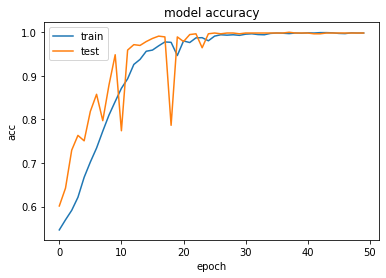

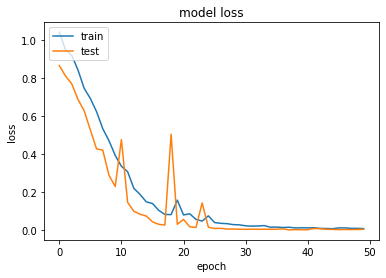

In [19]:
import matplotlib.pyplot as plt

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()